In [1]:
!git clone https://github.com/YuZhang-GitHub/Codebook_Learning_RL.git

Cloning into 'Codebook_Learning_RL'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 77 (delta 5), reused 0 (delta 0), pack-reused 59
Receiving objects: 100% (77/77), 14.41 MiB | 36.54 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
!pip install pfrl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pfrl: filename=pfrl-0.4.0-py3-none-any.whl size=155465 sha256=8c13d166e223f487bf1c7fca56efb33afac0e3d4954fe52b3268471baf3ee451
  Stored in directory: /root/.cache/pip/wheels/22/4a/0f/a87cd1ae925086eb3a1b8759f620fcf48e47939fb082946c3b
Successfully built pfrl


In [3]:
# from Codebook_Learning_RL import DDPG_classes

In [4]:
import os
os.chdir('/kaggle/working/Codebook_Learning_RL')
print(os.getcwd())

/kaggle/working/Codebook_Learning_RL


In [5]:
import pfrl
import os
import time
import torch
import numpy as np
import copy
import pickle
from torch import nn
from torch import distributions
from scipy.optimize import linear_sum_assignment
from DataPrep import dataPrep
from env_ddpg import envCB
from clustering import KMeans_only
from function_lib import bf_gain_cal, corr_mining
from DDPG_classes import OUNoise

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
class envCB_(envCB):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gain_history = [0]

In [7]:
options = {
        'gpu_idx': 0,
        'num_ant': 32,
        'num_bits': 4,
        'num_NNs': 4,  # codebook size
        'ch_sample_ratio': 0.5,
        'num_loop': 400,  # outer loop
        'target_update': 3,
        'path': './grid1101-1400.mat',
        'clustering_mode': 'random',
    }

train_opt = {
        'state': 0,
        'best_state': 0,
        'num_iter': 100,  # inner loop
        'tau': 1e-2,
        'overall_iter': 1,
        'replay_memory': [],
        'replay_memory_size': 8192,
        'minibatch_size': 1024,
        'gamma': 0,
        'gpu':0
    }
if not os.path.exists('beams/'):
    os.mkdir('beams/')

ch = dataPrep(options['path'])
ch = np.concatenate((ch[:, :options['num_ant']],
                     ch[:, int(ch.shape[1] / 2):int(ch.shape[1] / 2) + options['num_ant']]), axis=1)
with torch.cuda.device(options['gpu_idx']):
    u_classifier, sensing_beam = KMeans_only(ch, options['num_NNs'], n_bit=options['num_bits'], n_rand_beam=30)
    np.save('sensing_beam.npy', sensing_beam)
    sensing_beam = torch.from_numpy(sensing_beam).float().cuda()

    filename = 'kmeans_model.sav'
    pickle.dump(u_classifier, open(filename, 'wb'))

    # Quantization settings
    options['num_ph'] = 2 ** options['num_bits']
    options['multi_step'] = torch.from_numpy(
        np.linspace(int(-(options['num_ph'] - 2) / 2),
                    int(options['num_ph'] / 2),
                    num=options['num_ph'],
                    endpoint=True)).type(dtype=torch.float32).reshape(1, -1).cuda()
    options['pi'] = torch.tensor(np.pi).cuda()
    options['ph_table'] = (2 * options['pi']) / options['num_ph'] * options['multi_step']
    options['ph_table'].cuda()
    options['ph_table_rep'] = options['ph_table'].repeat(options['num_ant'], 1)
    actor_net_list = []
    critic_net_list = []
    actor_net_t_list = []
    critic_net_t_list = []
    ounoise_list = []
    env_list = []
    train_opt_list = []
    agent_list=[]

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
from pfrl.utils.batch_states import batch_states
def batch_experiences_(experiences, device, phi, gamma, batch_states=batch_states):
    """Takes a batch of k experiences each of which contains j

    consecutive transitions and vectorizes them, where j is between 1 and n.

    Args:
        experiences: list of experiences. Each experience is a list
            containing between 1 and n dicts containing
              - state (object): State
              - action (object): Action
              - reward (float): Reward
              - is_state_terminal (bool): True iff next state is terminal
              - next_state (object): Next state
        device : GPU or CPU the tensor should be placed on
        phi : Preprocessing function
        gamma: discount factor
        batch_states: function that converts a list to a batch
    Returns:
        dict of batched transitions
    """

    batch_exp = {
        "state": batch_states([elem[0]["state"] for elem in experiences], device, phi),
        "action": torch.as_tensor(
            np.array([elem[0]["action"] for elem in experiences]), device=device
        ),
        "reward": torch.as_tensor(
            [
                sum((gamma**i) * exp[i]["reward"] for i in range(len(exp)))
                for exp in experiences
            ],
            dtype=torch.float32,
            device=device,
        ),
        "next_state": batch_states(
            [elem[-1]["next_state"] for elem in experiences], device, phi
        ),
        "is_state_terminal": torch.as_tensor(
            [
                any(transition["is_state_terminal"] for transition in exp)
                for exp in experiences
            ],
            dtype=torch.float32,
            device=device,
        ),
        "discount": torch.as_tensor(
            [(gamma ** len(elem)) for elem in experiences],
            dtype=torch.float32,
            device=device,
        ),
    }
    if all(elem[-1]["next_action"] is not None for elem in experiences):
        batch_exp["next_action"] = torch.as_tensor(
            [elem[-1]["next_action"] for elem in experiences], device=device
        )
    return batch_exp

from pfrl.agents.ddpg import DDPG
class DDPG_(DDPG):
    def update(self, experiences, errors_out=None):
        """Update the model from experiences"""

        batch = batch_experiences_(experiences, self.device, self.phi, self.gamma)

        self.critic_optimizer.zero_grad()
        self.compute_critic_loss(batch).backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        self.compute_actor_loss(batch).backward()
        self.actor_optimizer.step()

        self.n_updates += 1

In [9]:
import pfrl
from pfrl import experiments, explorers, replay_buffers, utils
from pfrl.agents.ddpg import DDPG
from pfrl.nn import BoundByTanh, ConcatObsAndAction
from pfrl.policies import DeterministicHead
from pfrl.explorers import Greedy

def create_agent(state_size,action_size,train_options,gpu=0):
    
    #critic_network
    q_func = nn.Sequential(
        ConcatObsAndAction(),
        nn.Linear(state_size + action_size, 16*state_size),
        nn.ReLU(),
        nn.Linear(16*state_size, 16*action_size),
        nn.ReLU(),
        nn.Linear(16*action_size, 1),
    )
    #actor_network
    policy = nn.Sequential(
        nn.Linear(state_size, 16*state_size),
        nn.ReLU(),
        nn.Linear(16*state_size, 16*action_size),
        nn.ReLU(),
        nn.Linear(16*action_size, action_size),
        BoundByTanh(low= -torch.tensor(np.pi).float(), high= torch.tensor(np.pi).float()),
        DeterministicHead(),
    )
    
    opt_a = torch.optim.Adam(policy.parameters(), lr=1e-3, weight_decay=1e-3)
    opt_c = torch.optim.Adam(q_func.parameters(), lr=1e-3, weight_decay=1e-2)
    rbuf = replay_buffers.ReplayBuffer(train_options['replay_memory_size'])
    
    explorer =  Greedy()
    
    agent = DDPG_(
        policy,
        q_func,
        opt_a,
        opt_c,
        rbuf,
        gamma=train_options['gamma'],
        explorer = explorer,
        replay_start_size=train_options['minibatch_size'],
        target_update_method="soft",
        target_update_interval=options['target_update'],
        update_interval=1,
        soft_update_tau= train_opt['tau'],
        n_times_update=1,
        gpu=gpu,
        minibatch_size=train_options['minibatch_size'],
    )
    
    return agent


In [10]:
def create_agent_sac(state_size,action_size,train_options,gpu=0):
    def squashed_diagonal_gaussian_head(x):
        assert x.shape[-1] == action_size * 2
        mean, log_scale = torch.chunk(x, 2, dim=2)
        log_scale = torch.clamp(log_scale, -20.0, 2.0)
        var = torch.exp(log_scale * 2)
        base_distribution = distributions.Independent(
            distributions.Normal(loc=mean, scale=torch.sqrt(var)), 1
        )
        # cache_size=1 is required for numerical stability
        return distributions.transformed_distribution.TransformedDistribution(
            base_distribution, [distributions.transforms.TanhTransform(cache_size=1),
                                distributions.transforms.AffineTransform(0, torch.pi, event_dim=0, cache_size=1)]
        )

    #critic_networks
    q_func_1 = nn.Sequential(
        ConcatObsAndAction(),
        nn.Linear(state_size + action_size, 16*state_size),
        nn.ReLU(),
        nn.Linear(16*state_size, 16*action_size),
        nn.ReLU(),
        nn.Linear(16*action_size, 1),
    )
    q_func_2 = nn.Sequential(
        ConcatObsAndAction(),
        nn.Linear(state_size + action_size, 16*state_size),
        nn.ReLU(),
        nn.Linear(16*state_size, 16*action_size),
        nn.ReLU(),
        nn.Linear(16*action_size, 1),
    )
    
    #actor_network
    policy = nn.Sequential(
        nn.Linear(state_size, 16*state_size),
        nn.ReLU(),
        nn.Linear(16*state_size, 16*action_size),
        nn.ReLU(),
        nn.Linear(16*action_size, action_size* 2),
        pfrl.nn.lmbda.Lambda(squashed_diagonal_gaussian_head),
    )


    opt_a = torch.optim.Adam(policy.parameters(), lr=1e-3, weight_decay=1e-3)
    opt_c_1 = torch.optim.Adam(q_func_1.parameters(), lr=1e-3, weight_decay=1e-2)
    opt_c_2 = torch.optim.Adam(q_func_2.parameters(), lr=1e-3, weight_decay=1e-2)
    
    rbuf = replay_buffers.ReplayBuffer(train_options['replay_memory_size'])
    
    agent = pfrl.agents.SoftActorCritic(
        policy,
        q_func_1,
        q_func_2,
        opt_a,
        opt_c_1,
        opt_c_2,
        rbuf,
        gamma=train_options['gamma'],
        update_interval=1,
        replay_start_size=train_options['minibatch_size'],
        gpu=gpu,
        soft_update_tau= train_opt['tau'],
        minibatch_size = train_options['minibatch_size'],
        entropy_target=-action_size,
        temperature_optimizer_lr=1e-3,
    )
    return agent

In [11]:
def train(
          env,
          options,
          train_options,
          agent,
          ounoise,
          beam_id):
    
#     action_pred_noisy = ounoise.get_action(action_pred,
#                                                t=train_options['overall_iter'])
    CB_Env = env   
    if train_options['overall_iter'] == 1:
        state = torch.zeros((1, options['num_ant'])).float().cuda()
        print('Initial State Activated.')
    else:
        state = train_options['state']
    
    
    #training_loop
    iteration = 0
    num_of_iter = train_options['num_iter']  
    while iteration < num_of_iter:

        
        action = agent.act(state)
#         print(type(agent.batch_last_action),agent.batch_last_action)
        reward_pred, bf_gain_pred, action_quant_pred, state_1_pred = CB_Env.get_reward(torch.Tensor(action).to('cuda'))
        reward_pred = torch.from_numpy(reward_pred).float().cuda()
        
        action_pred_noisy = torch.Tensor(action).to('cuda')
        mat_dist = torch.abs(action_pred_noisy.reshape(options['num_ant'], 1) - options['ph_table_rep'])
        action_quant = options['ph_table_rep'][range(options['num_ant']), torch.argmin(mat_dist, dim=1)].reshape(1, -1)
   
        state_1, reward, bf_gain, terminal = CB_Env.step(action_quant)
        reward = torch.from_numpy(reward).float().cuda()
        action = action_quant.reshape((1, -1)).float().cuda()
        
        
#         print(type(action_quant_pred.cpu().numpy()),action_quant_pred.cpu().numpy().shape)
#         print(type(action.cpu().numpy()),action.cpu().numpy().shape)
        agent.replay_buffer.append(
                    state=state,
                    action=action_quant_pred.cpu().numpy(),
                    reward=reward_pred,
                    next_state=state_1_pred,
                    next_action=None,
                    is_state_terminal=terminal,
                    env_id=0,
                )
#         print(agent.batch_last_action,agent.batch_last_action[0].shape)
        agent.batch_last_action = [action.cpu().numpy()] #because the critic is expecting quantizazed actions
        agent.observe(state_1, reward, terminal, False)

        
        iteration += 1
        train_options['overall_iter'] += 1
        state = state_1
        
        new_gain = torch.Tensor.cpu(CB_Env.achievement).detach().numpy().reshape((1, 1))
        max_previous_gain = max(CB_Env.gain_history)
        if new_gain > max_previous_gain:
            CB_Env.gain_history.append(float(new_gain))                   
        else:
            CB_Env.gain_history.append(float(max_previous_gain))
            
    train_options['state'] = state  # used for the next loop
    train_options['best_state'] = CB_Env.best_bf_vec  # used for clustering and assignment
    if (train_options['overall_iter']-1)%500==0:
#         print(
#             "Beam: %d, Iter: %d, Reward: %d, BF Gain: %.2f" % \
#             (beam_id, 
#              train_options['overall_iter'],
#              int(torch.Tensor.cpu(reward).numpy().squeeze()),
#              torch.Tensor.cpu(bf_gain.detach()).numpy().squeeze(),))
        print(
            "Beam: %d, Iter: %d, Reward pred: %d, Reward: %d, BF Gain pred: %.2f, BF Gain: %.2f" % \
            (beam_id, train_options['overall_iter'],
             int(torch.Tensor.cpu(reward_pred).numpy().squeeze()),
             int(torch.Tensor.cpu(reward).numpy().squeeze()),
             torch.Tensor.cpu(bf_gain_pred.detach()).numpy().squeeze(),
             torch.Tensor.cpu(bf_gain.detach()).numpy().squeeze(),))      
    
    return train_options

In [12]:
for beam_id in range(options['num_NNs']):
    ounoise_list.append(OUNoise((1, options['num_ant'])))
    env_list.append(envCB_(ch, options['num_ant'], options['num_bits'], beam_id, options))
    train_opt_list.append(copy.deepcopy(train_opt))
    agent = create_agent_sac(options['num_ant'],options['num_ant'],train_opt_list[beam_id],gpu=train_opt['gpu'])
    agent_list.append(agent)
    ounoise_list.append(OUNoise((1, options['num_ant'])))

EGC bf gain:  231.17094
EGC bf gain:  231.17094
EGC bf gain:  231.17094
EGC bf gain:  231.17094


In [13]:
with torch.cuda.device(options['gpu_idx']):
    for sample_id in range(options['num_loop']):

        # ---------- Sampling ---------- #
        n_sample = int(ch.shape[0] * options['ch_sample_ratio'])
        ch_sample_id = np.random.permutation(ch.shape[0])[0:n_sample]
        ch_sample = torch.from_numpy(ch[ch_sample_id, :]).float().cuda()

        # ---------- Clustering ---------- #
    #     start_time = time.time()

        bf_mat_sample = bf_gain_cal(sensing_beam, ch_sample)
        # print("Clustering -1 uses %s seconds." % (time.time() - start_time))
        # start_time = time.time()
        f_matrix = corr_mining(bf_mat_sample)
        f_matrix_np = torch.Tensor.cpu(f_matrix).numpy()
        # print("Clustering 0 uses %s seconds." % (time.time() - start_time))
        # start_time = time.time()
        labels = u_classifier.predict(np.transpose(f_matrix_np).astype(float))

        # print("Clustering 1 uses %s seconds." % (time.time() - start_time))
        # start_time = time.time()

        user_group = []  # order: clusters
        ch_group = []  # order: clusters
        for ii in range(options['num_NNs']):
            user_group.append(np.where(labels == ii)[0].tolist())
            ch_group.append(ch_sample[user_group[ii], :])

    #     print("Clustering 2 uses %s seconds." % (time.time() - start_time))

        # ---------- Assignment ---------- #
    #     start_time = time.time()

        # best_state matrix
        best_beam_mtx = torch.zeros((options['num_NNs'], 2 * options['num_ant'])).float().cuda()
        for pp in range(options['num_NNs']):
            best_beam_mtx[pp, :] = env_list[pp].best_bf_vec
        gain_mtx = bf_gain_cal(best_beam_mtx, ch_sample)  # (n_beam, n_user)
        for ii in range(options['num_NNs']):
            if ii == 0:
                cost_mtx = torch.mean(gain_mtx[:, user_group[ii]], dim=1).reshape(options['num_NNs'], -1)
            else:
                sub = torch.mean(gain_mtx[:, user_group[ii]], dim=1).reshape(options['num_NNs'], -1)
                cost_mtx = torch.cat((cost_mtx, sub), dim=1)
        cost_mtx = -torch.Tensor.cpu(cost_mtx).numpy()
        row_ind, col_ind = linear_sum_assignment(cost_mtx)
        assignment_record = dict(zip(row_ind.tolist(), col_ind.tolist()))  # key: network, value: cluster
        for ii in range(options['num_NNs']):
            env_list[ii].ch = ch_group[assignment_record[ii]]

    #     print("Assignment uses %s seconds." % (time.time() - start_time))
        if (train_opt_list[beam_id]['overall_iter']-1)%500==0 or train_opt_list[beam_id]['overall_iter']==1:
            start_time = time.time()
        for beam_id in range(options['num_NNs']):
            train_opt_list[beam_id] = train(env_list[beam_id],options, train_opt_list[beam_id],agent_list[beam_id],ounoise_list[beam_id], beam_id)
        if (train_opt_list[beam_id]['overall_iter']-1)%500==0: 
            print("Training for 500 iteration for each Beam uses %s seconds." % (time.time() - start_time))

Initial State Activated.
Initial State Activated.
Initial State Activated.
Initial State Activated.
Beam: 0, Iter: 501, Reward pred: -1, Reward: -1, BF Gain pred: 2.36, BF Gain: 2.36
Beam: 1, Iter: 501, Reward pred: 1, Reward: 1, BF Gain pred: 32.36, BF Gain: 32.36
Beam: 2, Iter: 501, Reward pred: -1, Reward: -1, BF Gain pred: 0.81, BF Gain: 0.81
Beam: 3, Iter: 501, Reward pred: 1, Reward: 1, BF Gain pred: 12.67, BF Gain: 12.67
Training for 500 iteration for each Beam uses 12.760643482208252 seconds.


/opt/conda/lib/python3.10/site-packages/pfrl/replay_buffer.py:180: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  "action": torch.as_tensor(


Beam: 0, Iter: 1001, Reward pred: 1, Reward: 1, BF Gain pred: 14.76, BF Gain: 14.76
Beam: 1, Iter: 1001, Reward pred: -1, Reward: -1, BF Gain pred: 5.27, BF Gain: 5.27
Beam: 2, Iter: 1001, Reward pred: 1, Reward: 1, BF Gain pred: 10.62, BF Gain: 10.62
Beam: 3, Iter: 1001, Reward pred: 1, Reward: 1, BF Gain pred: 22.72, BF Gain: 22.72
Training for 500 iteration for each Beam uses 147.25154495239258 seconds.
Beam: 0, Iter: 1501, Reward pred: -1, Reward: -1, BF Gain pred: 3.23, BF Gain: 3.23
Beam: 1, Iter: 1501, Reward pred: 1, Reward: 1, BF Gain pred: 16.39, BF Gain: 16.39
Beam: 2, Iter: 1501, Reward pred: -1, Reward: -1, BF Gain pred: 2.08, BF Gain: 2.08
Beam: 3, Iter: 1501, Reward pred: 1, Reward: 1, BF Gain pred: 4.77, BF Gain: 4.77
Training for 500 iteration for each Beam uses 149.624418258667 seconds.
Beam: 0, Iter: 2001, Reward pred: 1, Reward: 1, BF Gain pred: 11.88, BF Gain: 11.88
Beam: 1, Iter: 2001, Reward pred: 1, Reward: 1, BF Gain pred: 27.96, BF Gain: 27.96
Beam: 2, Iter: 2

In [14]:
import numpy as np
import scipy.io as scio

num_ant = 32
num_beam = 4
results = np.empty((num_beam, 2*num_ant))

path = './beams/'

for beam_id in range(num_beam):
    fname = 'beams_' + str(beam_id) + '_max.txt'
    with open(path + fname, 'r') as f:
        lines = f.readlines()
        last_line = lines[-1]
        results[beam_id, :] = np.fromstring(last_line.replace("\n", ""), sep=',').reshape(1, -1)

results = (1 / np.sqrt(num_ant)) * (results[:, ::2] + 1j * results[:, 1::2])

scio.savemat('beam_codebook.mat', {'beams': results})

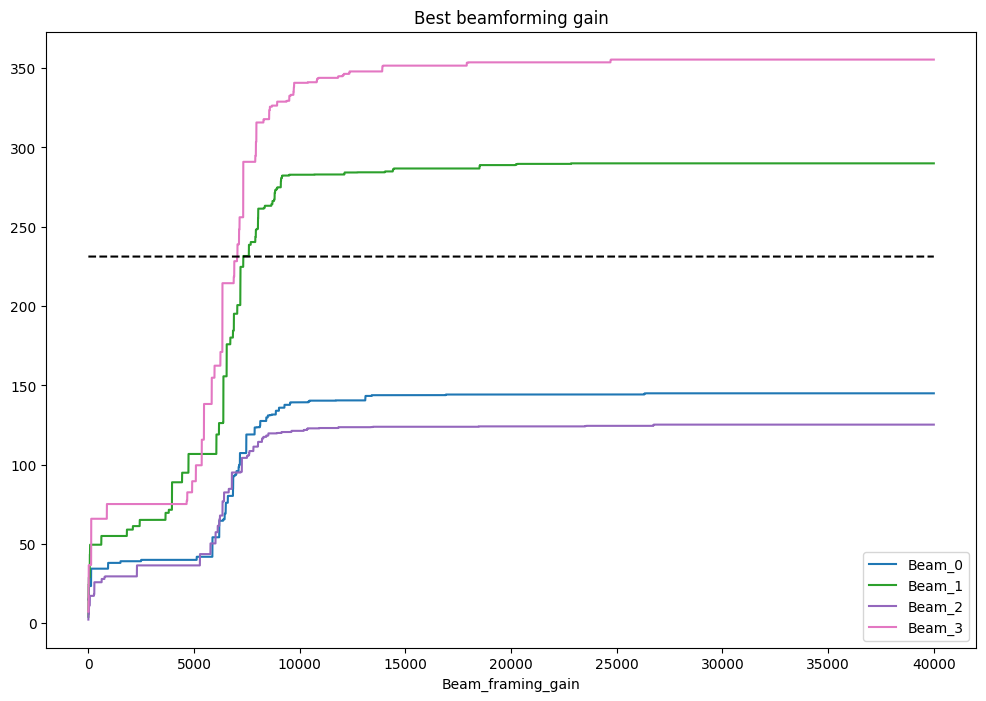

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 8))
plt.title(f'Best beamforming gain')
plt.xlabel('Beam_framing_gain')   
for beam_id in range(options['num_NNs']):
    gain_record=np.array(env_list[beam_id].gain_history[1:])
    np.save(f'beam_{beam_id}_gain_records',gain_record)
    plt.plot(gain_record, label=f'Beam_{beam_id}')
    plt.plot([])
plt.plot([231.17094]*40000,linestyle='dashed',color='black')
plt.legend(loc="lower right")  
plt.show()    